# Dealing with matrix data - Recurrent NN, Convolutional NN, & Graph NN

In this example we'll examine some of the ways in which we can deal with data which can be represented as a matrix, and how we can be efficient by using shared model weights to avoid having to use very large models.
1. Data is imported from H5 format
1. Data is preprocessed
1. Various models are trained and compared

### What is matrix data?

Matrix data can be used to describe a range of formats:
 - Data with an inherent order, such as text and time-series like audio, weather data, and stock prices;
 - Data with no inherent order, like an image, final-states in a particle collision, and members of a household
 
In each case there is some concept of an *object* with either a single feature or multiple features: Such objects and features could be:

- For text, each character (object) has a token value (feature). For time series, each discrete time-point or bin of time (object) can have e.g.: left and right audio channel values; mean temperature, humidity, rainfall, et cetera; mean trading price for several different stocks. In these examples an inherent order exists as it makes sense to move sequentially from one object to the next either forwards or backwards in time or through the text.
- Pixels (objects) in the image can have multiple channels (e.g. RGB), or a single channel (black and white), with each channel being a feature of the pixel. Whilst I say that images have no inherent order, each pixel of course has a position, however the image is best viewed instantaneously, however for computational reasons, some ordering is eventually required.
- Final-state particles and members of a household (objects) can have several features, e.g. 4-momenta, flavour, and charge, and e.g. age, education, and income. These provide a snapshot of some state, the result of a particle collision, and the status of a household at a given time point. Whilst it is possible to apply an ordering to the objects, e.g. by transverse momenta and age, the objects themselves have no inherent order.

Data of these kinds can be represented as a matrix of values, with either rows of objects and columns of features:

|        .         |Temperature|Humidity|Cloud cover|
|:---------------:|:---------:|:------:|:---------:|
|**t<sub>0</sub>**|     22    |    50  |    10     |
|**t<sub>1</sub>**|     23    |    50  |    11     |
|**t<sub>2</sub>**|     25    |    51  |    14     |
|**t<sub>3</sub>**|     24    |    51  |    15     |

Or vice versa, columns of objects with rows of values:

|  .   |  t<sub>0</sub>  |        t<sub>1</sub>    | t<sub>2</sub> | t<sub>3</sub> |
|:---:|:--------:|:-------------:|:-----:|:-----:|
|**Temperature**| 22 |  23 | 25 | 24|
|**Humidity**| 50 |    50   |  51  | 51|
|**Cloud cover** | 10 | 1 |   14  | 15|

In the examples we'll examine a few ways in which the data can be fed into a machine learning model, and in some cases we will need to assign an order to the data.

### Jet substructure

The data we will use for these examples are the constituents of jets, large collections particles which have been clustered together by some combination algorithm (such at [anti-k<sub>t</sub>](https://arxiv.org/abs/0802.1189)). Jets can be produced in particle collisions due to multiple reasons, such as the emission of an energetic light-quark or gluon (QCD) and the decay of some heavy particle (e.g. a *top* quark). Our data contains simulations for jets produced by both QCD interactions and hadronic top-quark decays, and our task is to learn to classify the production mechanism of each jet (either QCD - target 0, or top - target 1).

For each jet we have up to the first 200 jet constituents (our objects), which have been ordered by decreasing transverse momentum (*p<sub>t</sub>*), and we are provided with the Cartesian 4-momenta for each constituent: *p<sub>x</sub>*, *p<sub>y</sub>*, *p<sub>z</sub>*, and *E*.

This dataset is available from here https://desycloud.desy.de/index.php/s/llbX3zpLhazgPJ6, or by running the cell below. Warning, the dataset is quite large ~1.6 GB. A discussion of the dataset is documented here: https://docs.google.com/document/d/1Hcuc6LBxZNX16zjEGeq16DAzspkDC4nDTyjMp1bWHRo/edit, and the reference is "Deep-learned Top Tagging with a Lorentz Layer" by A Butter, G Kasieczka, T and M Russell ([arXiv: 1707.08966](https://arxiv.org/abs/1707.08966))

In [1]:
#!mkdir data
#!wget -O data/v0.zip https://desycloud.desy.de/index.php/s/llbX3zpLhazgPJ6/download?path=%2F&files=train.h5
#!unzip data/v0.zip
#!mv data/v0 data/top
#!rm data/v0.zip

If running in Google Collab, uncomment and run the cell below to install LUMIN

In [2]:
# !pip install lumin
# !git clone https://github.com/SauceCat/PDPbox.git && cd PDPbox && pip install -e .

--> **RESTART INSTANCE TO ENSURE PDPBOX IS FOUND** <--

## Basic Modules

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle
from typing import *
from functools import partial

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Loading

In [4]:
from pathlib import Path
PATH = Path('data/top/')

The dataset is stored as an `HDFStore`, meaning that we only need to load the data points we want into memory

In [5]:
trn_store = pd.HDFStore(PATH/'train.h5')

In [6]:
def load_df(store:pd.io.pytables.HDFStore, n_evts:Optional[int]=None, n_const:Optional[int]=None) -> pd.DataFrame:
    df = trn_store.select("table",stop=n_evts).drop(columns=['truthE','truthPX','truthPY','truthPZ','ttv'])
    if n_const is not None: df.drop(columns=[f for f in df.columns if f != 'is_signal_new' and int(f[f.find('_')+1:]) >= n_const], inplace=True)
    rename = {f:f'{f[f.find("_")+1:]}_{f[:f.find("_")].lower()}' for f in df.columns if f != 'is_signal_new'}
    rename['is_signal_new'] = 'gen_target'
    df.rename(columns=rename, inplace=True)
    return df

Since we want to run this example in a reasonable time, we'll only load a subset of events, and only the first 15 jet constituents

In [7]:
df = load_df(trn_store, 100000, 15)
train_feats = [f for f in df.columns if f != 'gen_target']

In [8]:
df.head()

,0_e,0_px,0_py,0_pz,1_e,1_px,1_py,1_pz,2_e,2_px,...,12_pz,13_e,13_px,13_py,13_pz,14_e,14_px,14_py,14_pz,gen_target
375,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,-5.168633,5.772969,-2.934152,-2.741892,-4.147282,3.760998,-2.126343,-1.726225,-2.577580,0
377,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,-5.169344,12.235772,9.495658,6.468640,-4.207529,12.144011,9.618115,6.238667,-4.005982,0
378,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,18.894077,15.164075,1.630675,-8.673338,12.331393,15.519842,1.450881,-8.650339,12.803596,0
379,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,-16.163919,9.674562,2.913741,-1.988122,-9.008586,7.635000,2.944075,-0.764874,-7.002900,0
380,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,-17.005817,20.348495,-8.120813,-2.914289,-18.428799,18.113104,-8.147335,-1.894768,-16.065968,0


So we have our data in flat format with each row corresponding to a jet, with `gen_target` indicating the class, and features of the jet constituents as the columns.

We'll want to preprocess the data a bit to make it easier to train on:
- Not all jets are guaranteed to have the same number of jet constituents, and where they are nonexistent, their feature values are set to zero. Later on we will be standardising and normalising the features and do not want to be biased by this default value, so we will replace it them `NaN`.
- We are told the absolute position of each constituent, however since the detector is a cylinder with azimuthal and longitudinal symmetry, what really matters is the relative positions of the constituents compared to one another. In order to factor out this symmetry, we'll rotate and flip the jets to have the first constituent at $\phi=0$, and in the positive *z* direction, and then flip the jet again to have the second constituent in the positive $\phi$ direction.
- Finally we'll standardise and normalise each feature of each of the constituents.

In [9]:
from lumin.data_processing.pre_proc import fit_input_pipe
from lumin.data_processing.hep_proc import to_pt_eta_phi, proc_event, get_vecs

def proc_df(df:pd.DataFrame, train_feats:List[str]) -> None:
    print('Moving to float32')
    df[train_feats] = df[train_feats].values.astype('float32')
    print('Replacing zeros')
    df[train_feats] = df[train_feats].replace(0.0, np.nan)  # Don't bias preprocessing with non-existent tracks
    print('Converting vectors')
    for v in get_vecs(train_feats): to_pt_eta_phi(df, v, True)    
    print('Processing event')
    proc_event(df, fix_phi=True, fix_y=True, fix_z=True, ref_vec_0='0', ref_vec_1='1', use_cartesian=True)
    print('Readding 0_py')
    df['0_py'] = 0.
    print('Preprocessing features')
    print('Fitting preproc pipe')
    input_pipe = fit_input_pipe(df, train_feats, PATH/'input_pipe')
    print('Transforming features')
    df[train_feats] = input_pipe.transform(df[train_feats])  # Rescale and shift track momenta values

In [10]:
proc_df(df, train_feats)

Moving to float32
Replacing zeros
Converting vectors
Processing event
Setting 0 to phi = 0
Setting 1 to positve phi
Setting 0 to positive eta
Converting to use_cartesian coordinates
Readding 0_py
Preprocessing features
Fitting preproc pipe
Transforming features


## Saving

Processing our flat data into a matrix can be done in two different ways:
 - Processing the flat data into matrices and saving them
 - Saving the flat data and processing it into matrices on the fly
 
We'll use the second case for now, since it is more flexible, and currently faster. However in both cases we need to have a list of vector (objects) and a list of features per vector. Whether or not the matrix should be row-wise or column-wise can be configured later.

The order of the list of vectors will determine the ordering of the objects in the matrix, regardless of whether that ordering matters. We'll stick with the default ordering of the data.

In [11]:
from lumin.data_processing.hep_proc import get_vecs

fpv = ['px', 'py', 'pz', 'e']
vecs = [str(i) for i in sorted([int(f) for f in get_vecs(train_feats)])]
fpv, vecs

(['px', 'py', 'pz', 'e'],
 ['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14'])

In [12]:
from lumin.data_processing.file_proc import df2foldfile
from lumin.nn.data.fold_yielder import *

def df2fy(df:pd.DataFrame, train_feats:List[str], n_folds:int=10) -> None:
    df2foldfile(df=df, n_folds=n_folds,
                cont_feats=train_feats, cat_feats=[], targ_feats='gen_target',
                savename=PATH/'train', targ_type='int', strat_key='gen_target')

In [13]:
train_fy = df2fy(df, train_feats)

Saving fold 0 with 10000 events
Saving fold 1 with 10000 events
Saving fold 2 with 10000 events
Saving fold 3 with 10000 events
Saving fold 4 with 10000 events
Saving fold 5 with 10000 events
Saving fold 6 with 10000 events
Saving fold 7 with 10000 events
Saving fold 8 with 10000 events
Saving fold 9 with 10000 events


In [14]:
from lumin.nn.data.fold_yielder import FoldYielder

train_fy = FoldYielder(PATH/'train.hdf5')

## Model Building

We'll be trying out several different models, but in each case we'll mostly be changing the `head` of the model, so let's write a function to return a suitable `ModelBuilder` from a few arguments.

In [15]:
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.helpers import CatEmbedder
from lumin.nn.models.blocks.head import *
from lumin.nn.models.blocks.head import AbsHead
from typing import *
from torch import nn

In [16]:
bs = 256
objective = 'classifier'
n_out = 1

def get_model_builder(fy:FoldYielder, depth:int, width:int, head:AbsHead=CatEmbHead) -> ModelBuilder:
    opt_args = {'opt':'adam', 'eps':1e-08}
    cat_embedder = CatEmbedder.from_fy(fy)
    body = partial(FullyConnected, depth=depth, width=width, act='swish')
    model_builder = ModelBuilder(objective, cont_feats=fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder, 
                                 opt_args=opt_args, body=body, head=head)
    print(Model(model_builder))
    return model_builder

## DNN

The basic approach to inputting the data is to keep the data flat and feed every single feature into the model simultaneously. Using the first 15 constituents, we have 60 input features and as we increase the number of constituents, the number of inputs would grow considerably. This means that the number of parameters in the input layer of our DNN would also grow.

The aim will be to try and replace this fully-connected input layer with a more efficient layer. Nonetheless, the DNN allows all constituents to be considered simultaneously, so should theoretically offer the best performance, provided it can be trained.

For our tests, we'll use a DNN with 4 hidden layers of 50 neurons, and for later examples, drop a hidden layer in favour of a different input head.

In [17]:
model_builder = get_model_builder(train_fy, depth=4, width=50)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead()
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=60, out_features=50, bias=True)
        (1): Swish()
      )
      (1): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): Swish()
      )
      (2): Sequential(
        (0

So, our baseline model uses 10751 parameters. Let's train it and check the score. We'll use the area under the ROC curve as a metric

In [18]:
from sklearn.metrics import roc_auc_score
from lumin.nn.metrics.eval_metric import EvalMetric

class AUC(EvalMetric):
    def __init__(self, wgt_name:Optional[str]=None, targ_name:str='targets'):
        super().__init__(targ_name=targ_name, wgt_name=wgt_name)

    def evaluate(self, fy:FoldYielder, idx:int, y_pred:np.ndarray) -> float:
        df = self.get_df(fy, idx, y_pred)
        return roc_auc_score(df['gen_target'], df['pred'])

LR finder took 1.286s 


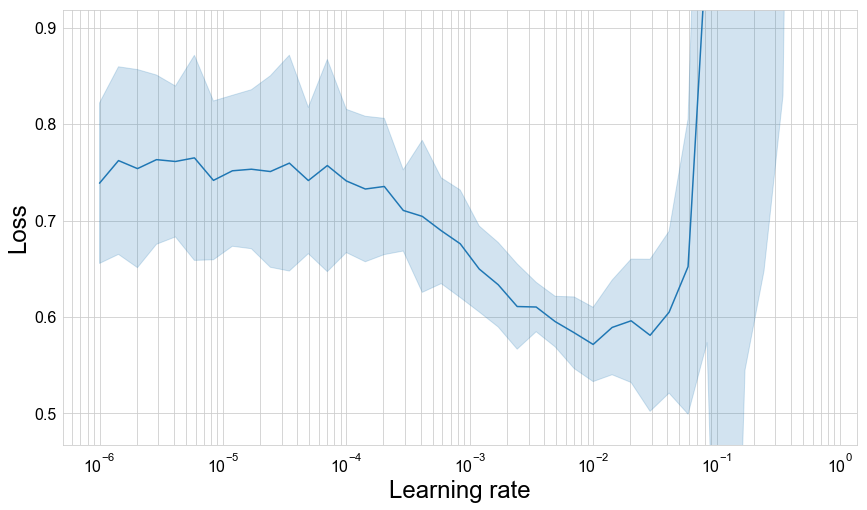

In [19]:
from lumin.optimisation.hyper_param import fold_lr_find

lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

In [20]:
from lumin.nn.callbacks.cyclic_callbacks import *
from functools import partial

callback_partials = [partial(OneCycle, lengths=[45, 90], lr_range=[1e-4, 1e-2], mom_range=[0.85, 0.95], interp='cosine')]
eval_metrics = {'AUC':AUC(wgt_name='weights')}

Training model 1 / 1, Val ID = 0


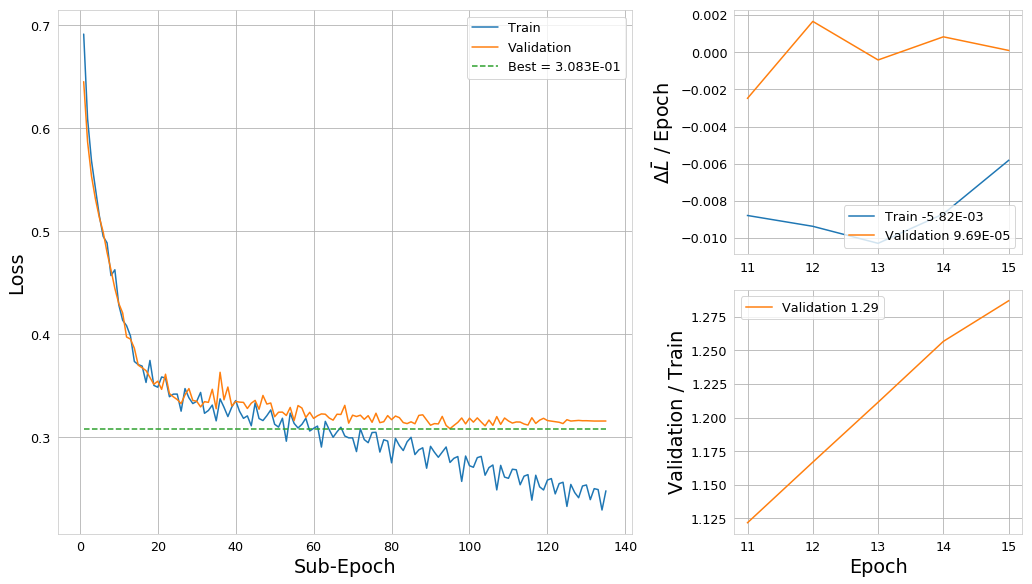

Early stopping after 135 epochs
Scores are: {'loss': 0.3082718849182129, 'AUC': 0.9309112157831781}
Fold took 25.760s


______________________________________
Training finished
Cross-validation took 26.209s 


<Figure size 1024x576 with 0 Axes>

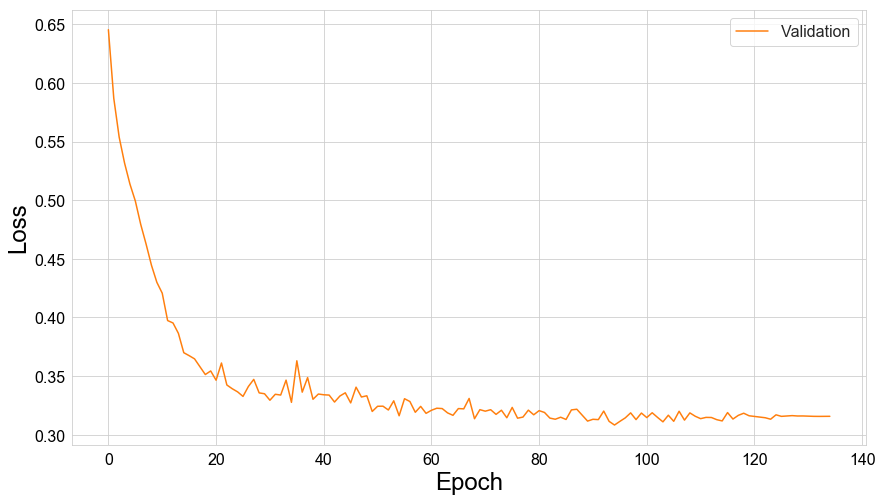

Mean loss = 0.3082718849182129±0.0
Mean AUC = 0.9309112157831781±0.0
______________________________________



In [21]:
from lumin.nn.training.fold_train import fold_train_ensemble

_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

Our DNN achieves a validation AUC of 0.931

## Recurrent NN

One approach is to use and RNN (see e.g. [Stanford CS-230](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks)) to feed in each jet constituent to a small hidden layer and combining the hidden-state with the hidden state of the previous jet constituent. In this way some interaction between the jet constituents can be modeled, despite all of them not being simultaneously accessible.

LSTMs and GRUs can also be used to help deal with longer sequences of inputs, i.e. modeling interactions between more jet constituents. The matrix format for RNNs is row-wise, with each row of features corresponding to a single jet constituent:

| .   |        px |        py |        pz |         e |
|---:|----------:|----------:|----------:|----------:|
|  0 |  2.30719  |  0        |  1.01265  |  1.37771  |
|  1 | -0.276425 |  0.115836 | -0.163387 | -0.32702  |
|  2 |  0.896027 | -0.247819 |  0.298258 |  0.356868 |
|  3 | -0.804857 | -0.330734 | -0.323842 | -0.621516 |


The [`RecurrentHead`](https://lumin.readthedocs.io/en/latest/lumin.nn.models.blocks.html#lumin.nn.models.blocks.head.RecurrentHead) class will automatically transform flat data into this format. It also has various arguments for stacking layers, changing the whether to use `nn.RNN`, `nn.LSTM`, or `nn.GRU`, the width, dropout, activation function, and whether to run in bidirectional mode - this means that the sequence will first be fed in as provided, and then will be fed in again into a separate series of weights, but this time in reverse, lessening the dependence of the model's performance on getting the optimal ordering of the inputs.

In [22]:
head = partial(RecurrentHead, vecs=vecs, feats_per_vec=fpv,
               depth=1, width=10, rnn=nn.GRU, bidirectional=True)
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): RecurrentHead(
    (rnn): GRU(4, 10, batch_first=True, bidirectional=True)
  )
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=20, out_features=50, bias=True)
        (1): Swish()
      )
      (1): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=Tr

So with a basic GRU, we're down to just 7161 parameters. Lets see how well it performs.

LR finder took 1.814s 


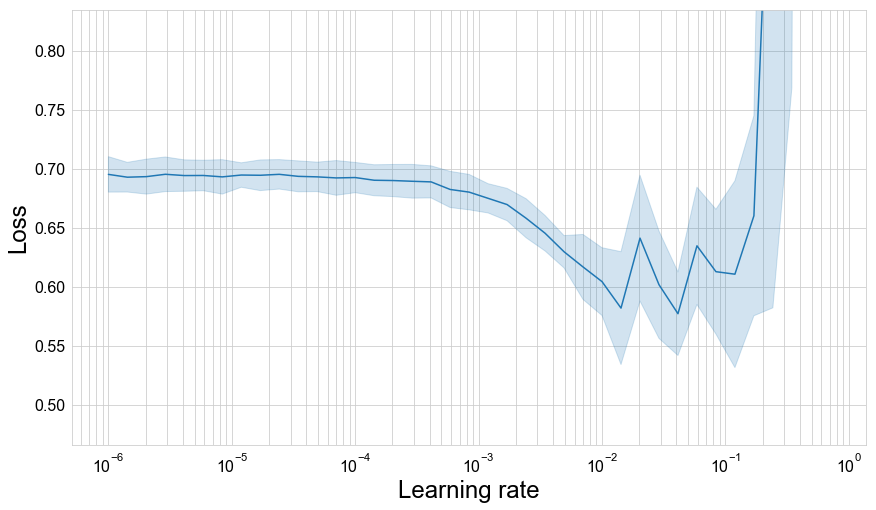

In [23]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

Training model 1 / 1, Val ID = 0


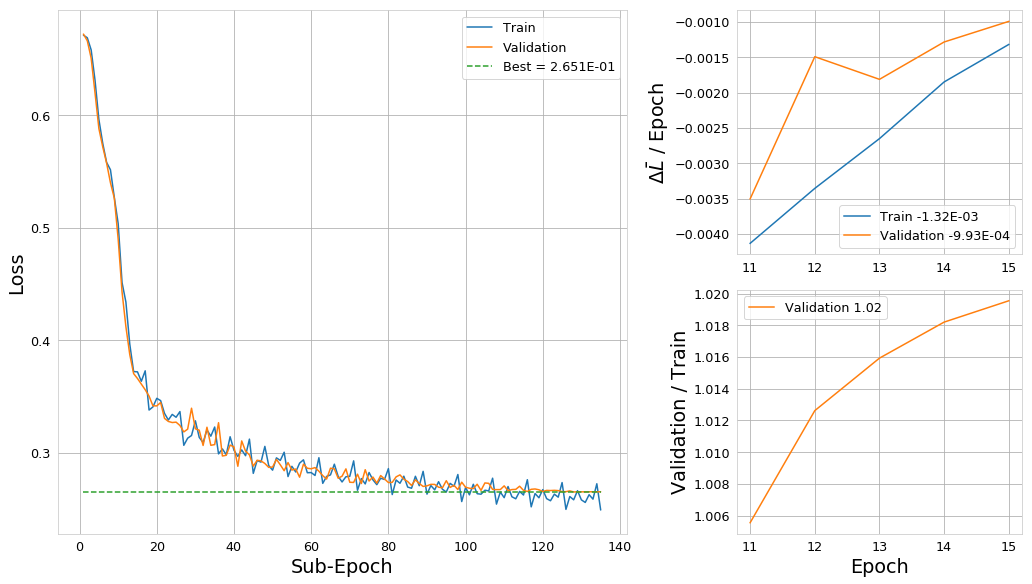

Early stopping after 135 epochs
Scores are: {'loss': 0.2650603950023651, 'AUC': 0.9485683470837422}
Fold took 33.512s


______________________________________
Training finished
Cross-validation took 33.955s 


<Figure size 1024x576 with 0 Axes>

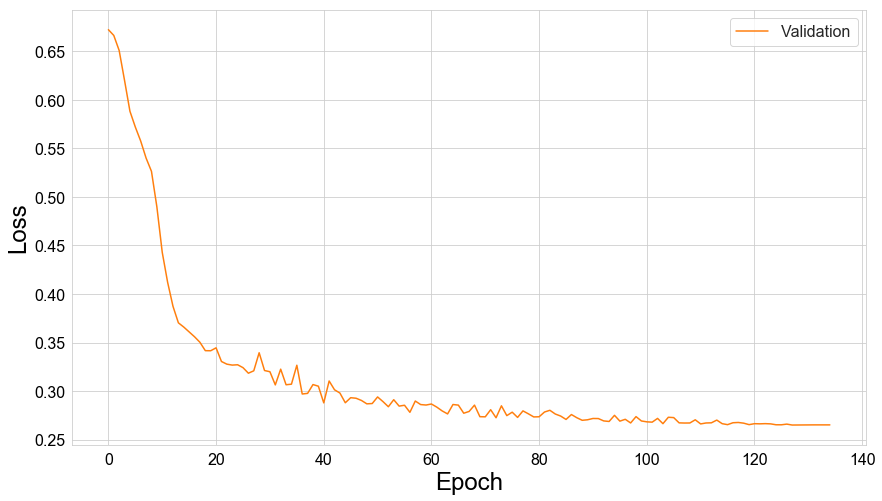

Mean loss = 0.2650603950023651±0.0
Mean AUC = 0.9485683470837422±0.0
______________________________________



In [24]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

So not only did we reduce the number of free parameters, the score also improved to 0.949

## CNN

An alternative approach to weight sharing is to instead learn kernel functions (small matrices of weights), which are then scanned across the input matrix; a Convolutional Neural Network. In 1D convolutions, each kernel 'sees' all features for multiple objects simultaneously, allowing them to model interactions between objects. See e.g. [Stanford CS-230](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks), for more details.

1D CNNs act on column-wise input data, i.e matrices in which each column corresponds to an object (jet constituent) and each row corresponds to a feature and 

| .   |        px |        py |        pz |         e |
|---:|----------:|----------:|----------:|----------:|
|  0 |  2.30719  |  0        |  1.01265  |  1.37771  |
|  1 | -0.276425 |  0.115836 | -0.163387 | -0.32702  |
|  2 |  0.896027 | -0.247819 |  0.298258 |  0.356868 |
|  3 | -0.804857 | -0.330734 | -0.323842 | -0.621516 |

A kernel of size 3, for example, would cover three columns (with padding=0) at a time.

CNN architectures are constantly changing, and are an active area of research. Lumin includes a basic abstract class [`AbsConv1dHead`](https://lumin.readthedocs.io/en/latest/lumin.nn.models.blocks.html#lumin.nn.models.blocks.head.AbsConv1dHead) with the idea that users can inherit from this to define their own CNN architectures. Let's do that and construct a basic CNN.

The main function we want to override is `get_layers`, which gets called during intialisation and should return an `nn.Module` which will return a flat tensor when its `forward` method is called; i.e. the layers defined should take in the matrix data, perform various calculations on in, and collapse it down to flat data. Similar to `RecurrentHead`, `AbsConv1dHead` will automatically reshape the data if passed a flat input.

In [25]:
class CNN(AbsConv1dHead):
    def get_layers(self, in_c:int, act:str='relu', bn:bool=False, **kargs) -> Tuple[nn.Module, int]:    
        layers = []
        layers.append(self.get_conv1d_block(in_c, 16, stride=1, kernel_sz=3, act=act, bn=bn))
        layers.append(self.get_conv1d_block(16, 16, stride=1, kernel_sz=3, act=act, bn=bn))
        layers.append(self.get_conv1d_block(16, 32, stride=2, kernel_sz=3, act=act, bn=bn))
        layers.append(nn.AdaptiveAvgPool1d(1))
        layers = nn.Sequential(*layers)
        return layers

`AbsConv1dHead` includes several helper functions to easily construct convolutional layers. These actually instantiate [`Conv1DBlock`](https://lumin.readthedocs.io/en/latest/lumin.nn.models.blocks.html#lumin.nn.models.blocks.conv_blocks.Conv1DBlock) objects.
There are similar functions and blocks for ResNet and ReNeXt layers, and this list will probably be expanded to include other connections as well.

In [26]:
head = partial(CNN, vecs=vecs, feats_per_vec=fpv, act='swish', bn=True)
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CNN(
    (layers): Sequential(
      (0): Conv1DBlock(
        (layers): Sequential(
          (0): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): Swish()
          (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Conv1DBlock(
        

LR finder took 2.048s 


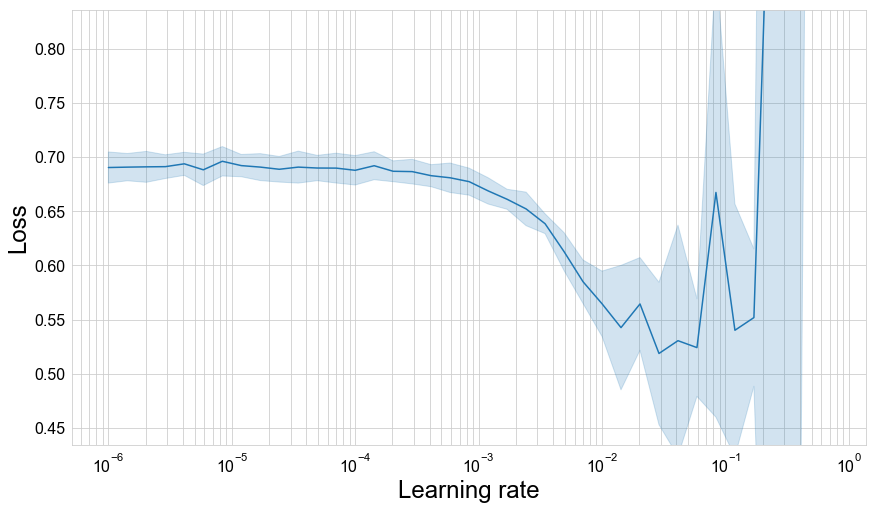

In [27]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

Training model 1 / 1, Val ID = 0


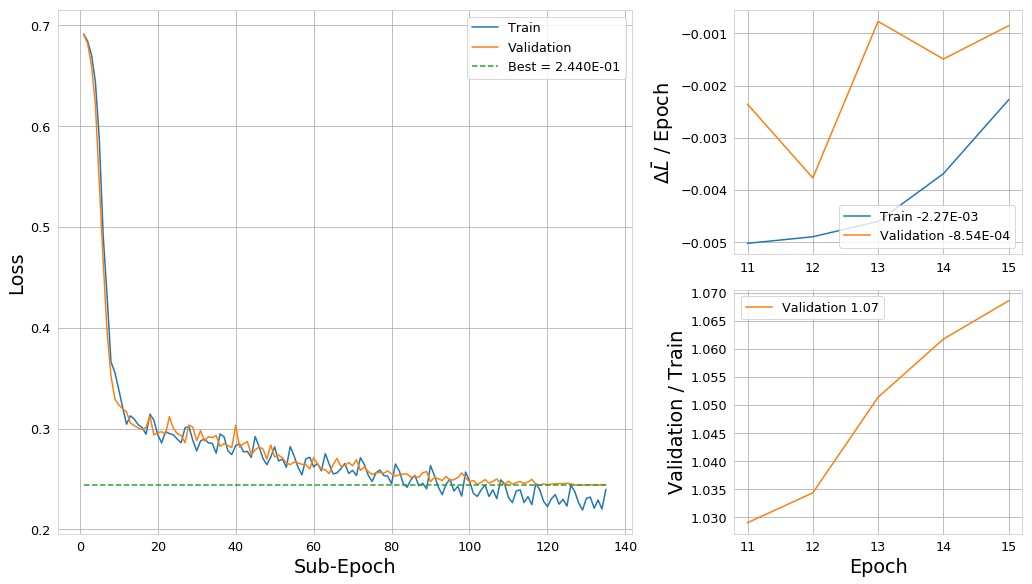

Early stopping after 135 epochs
Scores are: {'loss': 0.24403530359268188, 'AUC': 0.959955534371542}
Fold took 34.931s


______________________________________
Training finished
Cross-validation took 35.360s 


<Figure size 1024x576 with 0 Axes>

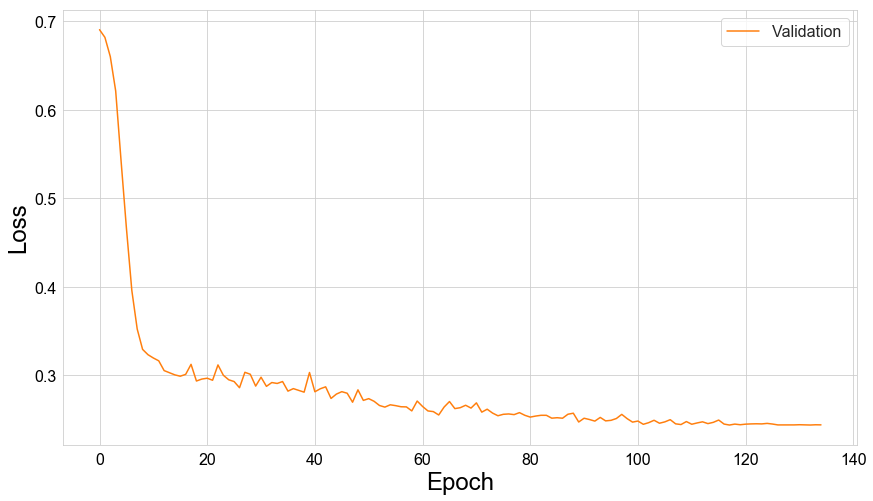

Mean loss = 0.24403530359268188±0.0
Mean AUC = 0.959955534371542±0.0
______________________________________



In [28]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

Even better, 0.960

### ResNet

Example of building a ResNet CNN. Note that the default configuration is pre-activation.

In [29]:
class ResNet(AbsConv1dHead):
    def get_layers(self, in_c:int, act:str='relu', bn:bool=False, **kargs) -> Tuple[nn.Module, int]:    
        layers = []
        layers.append(self.get_conv1d_block(in_c, 16, stride=1, kernel_sz=3, act='linear', bn=False))
        layers.append(self.get_conv1d_res_block(16, 16, stride=1, kernel_sz=3, act=act, bn=bn))
        layers.append(self.get_conv1d_res_block(16, 32, stride=2, kernel_sz=3, act=act, bn=bn))
        layers.append(nn.AdaptiveAvgPool1d(1))
        layers = nn.Sequential(*layers)
        return layers

In [30]:
head = partial(ResNet, vecs=vecs, feats_per_vec=fpv, act='swish', bn=True)
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): ResNet(
    (layers): Sequential(
      (0): Conv1DBlock(
        (layers): Sequential(
          (0): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        )
      )
      (1): Res1DBlock(
        (layers): Sequential(
          (0): Sequential(
            (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=Tr

LR finder took 2.627s 


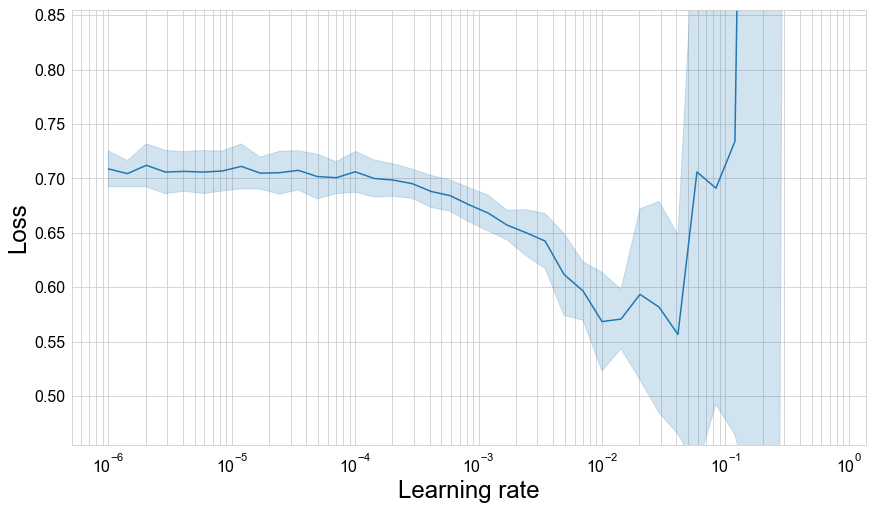

In [31]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

Training model 1 / 1, Val ID = 0


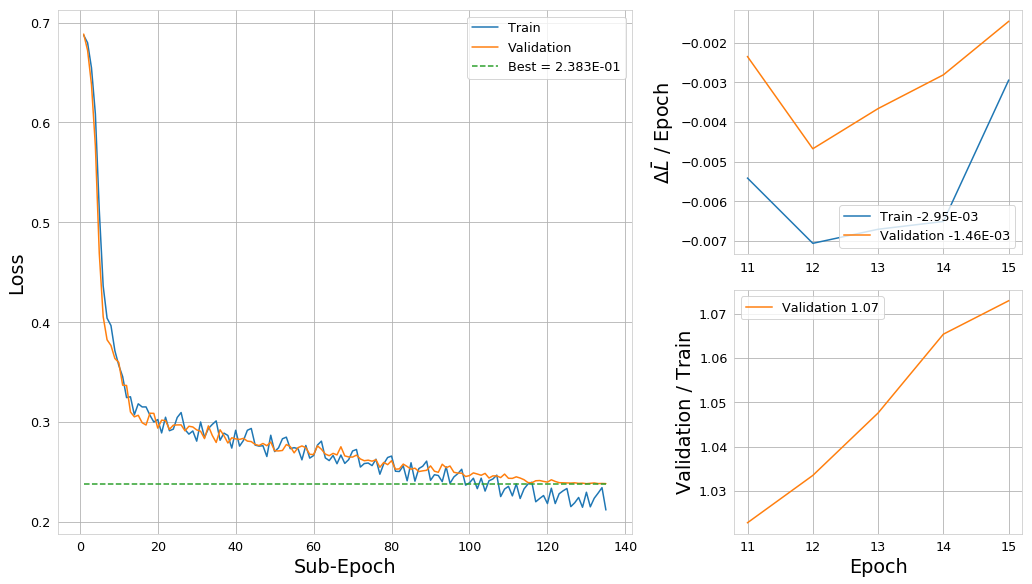

Early stopping after 135 epochs
Scores are: {'loss': 0.23830686509609222, 'AUC': 0.9619732556628835}
Fold took 40.919s


______________________________________
Training finished
Cross-validation took 41.354s 


<Figure size 1024x576 with 0 Axes>

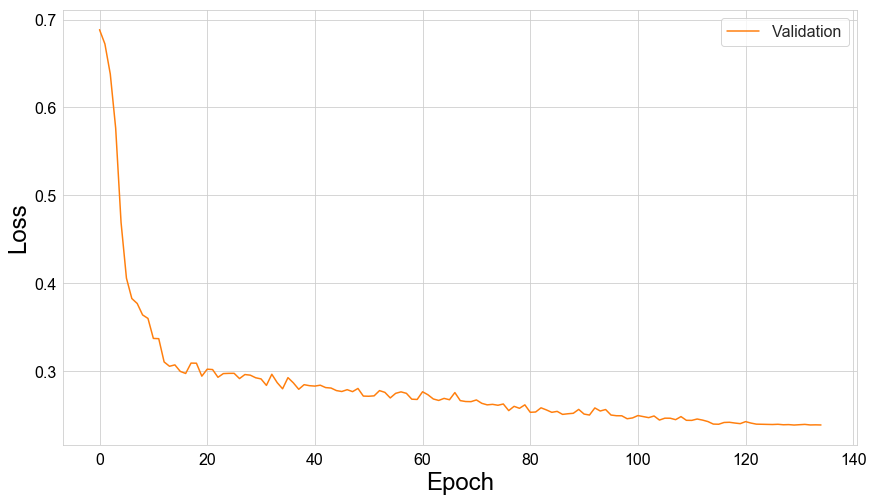

Mean loss = 0.23830686509609222±0.0
Mean AUC = 0.9619732556628835±0.0
______________________________________



In [32]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

A larger model than the DNN, but the main point was to demonstrate building a ResNet model. Gets slight better performance, though, at 0.962

### ResNeXt
Another example, showing a pre-activation RexNeXt architecture

In [33]:
class ResNeXt(AbsConv1dHead):
    def get_layers(self, in_c:int, act:str='relu', bn:bool=False, **kargs) -> Tuple[nn.Module, int]:    
        layers = []
        layers.append(self.get_conv1d_block(in_c, 32, stride=1, kernel_sz=3, act='linear', bn=False))
        layers.append(self.get_conv1d_resNeXt_block(32, 4,4,32, stride=1, kernel_sz=3, act=act, bn=bn))
        layers.append(self.get_conv1d_resNeXt_block(32, 4,4,64, stride=2, kernel_sz=3, act=act, bn=bn))
        layers.append(nn.AdaptiveAvgPool1d(1))
        layers = nn.Sequential(*layers)
        return layers

In [34]:
head = partial(ResNeXt, vecs=vecs, feats_per_vec=fpv, act='swish', bn=True)
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): ResNeXt(
    (layers): Sequential(
      (0): Conv1DBlock(
        (layers): Sequential(
          (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        )
      )
      (1): ResNeXt1DBlock(
        (layers): Sequential(
          (0): Sequential(
            (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affi

LR finder took 3.219s 


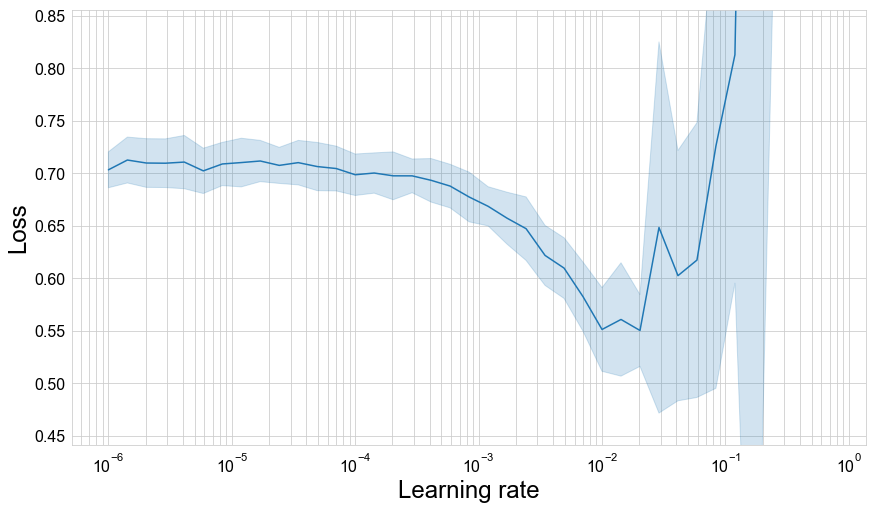

In [35]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

Training model 1 / 1, Val ID = 0


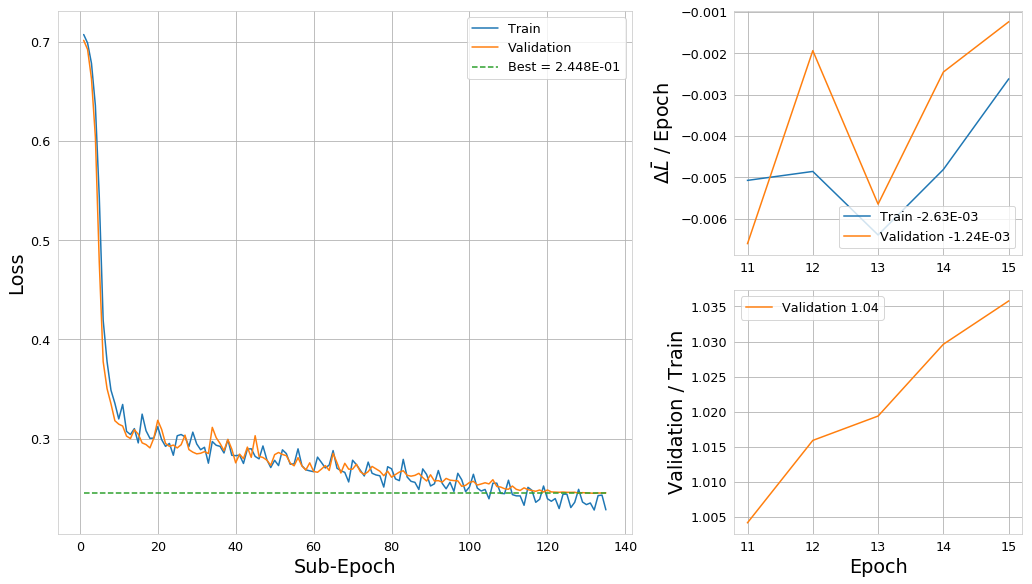

Early stopping after 135 epochs
Scores are: {'loss': 0.2448488473892212, 'AUC': 0.9588912336903894}
Fold took 47.821s


______________________________________
Training finished
Cross-validation took 48.310s 


<Figure size 1024x576 with 0 Axes>

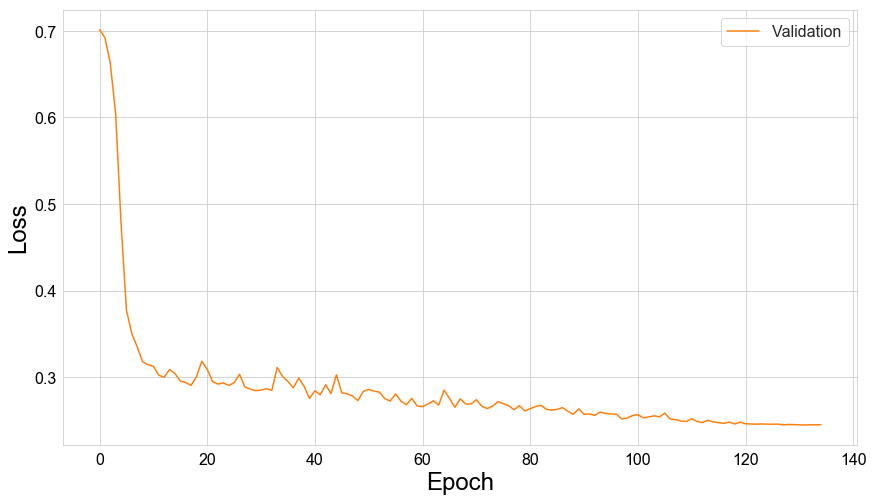

Mean loss = 0.2448488473892212±0.0
Mean AUC = 0.9588912336903894±0.0
______________________________________



In [36]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

An even larger model this time, but performance is slightly worse than ResNet

## Interaction Net

Both RNN and CNN architectures rely on an assigned ordering of the objects, since they do not consider all objects simultaneously. This can have an effect on their performance is the ordering applied is suboptimal, particularly if the objects to not have an inherent ordering. Graph Networks instead aim to model the interactions between objects without assuming any ordering, and do so using small neural networks which are shared between objects.

One such approach is the [Interaction Network](https://arxiv.org/abs/1612.00222), applied in similar context in [Moreno et al 2019](https://arxiv.org/abs/1908.05318), who also give a very comprehensive explanation of how the approach works using the diagram:

<img src="imgs/in.png" width="512">

In the IN, each column of objects are allowed to interact with each other column to form an internal representation modeled using a single neural network, which is applied to all pairs of interactions. This internal representation is then concatenated with the original input matrix, and a second neural network is applied column-wise to form a post-interaction representation.

At this point the post-interaction matrix must be transformed into a flat representation, by perhaps summing over columns for each row (which retains the invariance of the data to ordering), flattening the matrix out, or something more advanced (like feeding the matrix to a small RNN, CNN, or pooling layer). The latter two choices are likely to then require some ordering to the input data to ensure it is consistent between datapoints, which may affect performance. 

Graph nets are looking to be quite a promising technique in HEP, but so far I've only implemented [`InteractionNet`](InteractionNet). When configuring it:
- `intfunc` refers to the first network, which is used to build the internal representation
- `outfunc` refers to the second network, which builds the post-interaction representation
- `agg_method` configures the way in which the post-interaction matrix is flattened with either `flatten` to squash the matrix whilst retaining each element, or `sum` to sum across columns for each row retaining the order-invariance of the input data.

In [37]:
head = partial(InteractionNet, intfunc_depth=3,intfunc_width=20,intfunc_out_sz=10,
               outfunc_depth=3,outfunc_width=20,outfunc_out_sz=4,agg_method='flatten',
               feats_per_vec=fpv,vecs=vecs, act='swish')
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): InteractionNet(
    (fr): Sequential(
      (0): Sequential(
        (0): Linear(in_features=8, out_features=20, bias=True)
        (1): Swish()
      )
      (1): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Swish()
      )
      (2): Sequential(
        (0): Linear(in_features=20,

LR finder took 2.013s 


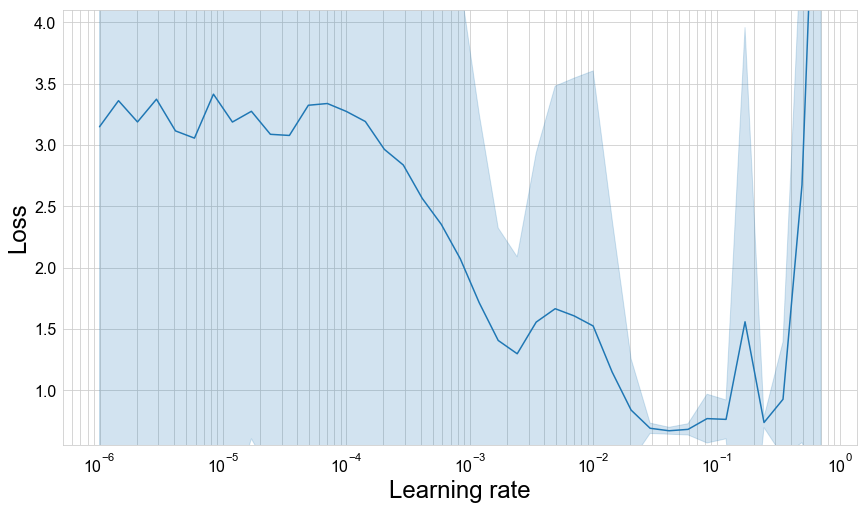

In [38]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

In [39]:
callback_partials[0].keywords['lr_range'] = [2e-4, 2e-2]

Training model 1 / 1, Val ID = 0


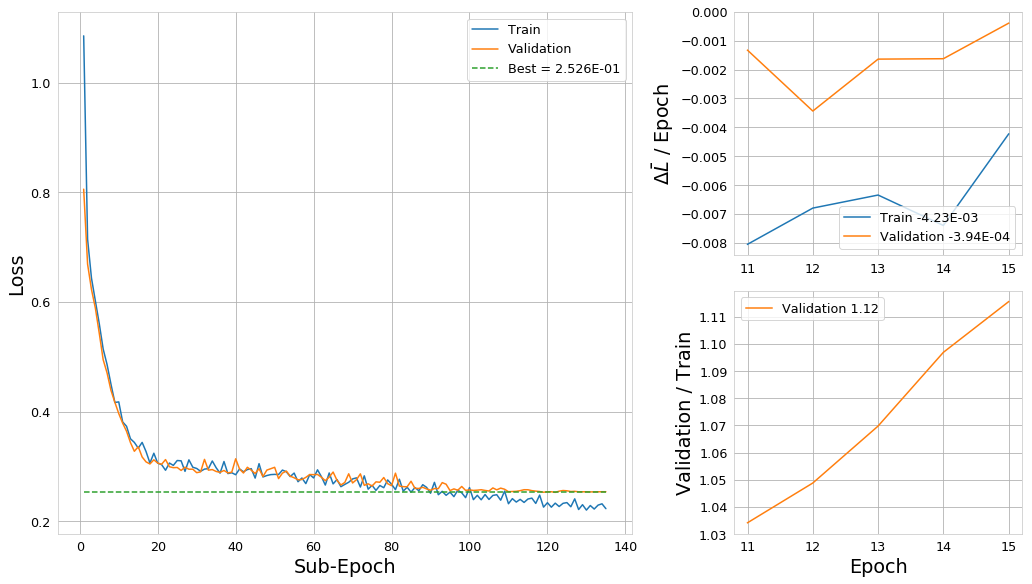

Early stopping after 135 epochs
Scores are: {'loss': 0.2526407241821289, 'AUC': 0.9559359717990219}
Fold took 38.135s


______________________________________
Training finished
Cross-validation took 38.585s 


<Figure size 1024x576 with 0 Axes>

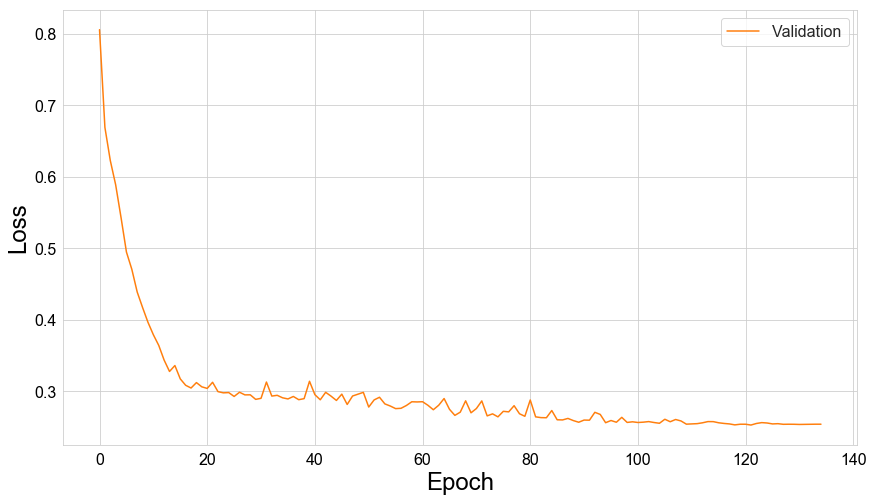

Mean loss = 0.2526407241821289±0.0
Mean AUC = 0.9559359717990219±0.0
______________________________________



In [40]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

Still not as good as ResNet, and slow to train for its size. There are quite a few hyper-parameters to play with, though.

## Multiple data sources

It could well be the case that one has data will several formats, are processed by separate heads before being combined. We've seen that it is useful to process the jet constituents as matrices, but what if we also have other information about the jet which we also want to include as flat continuous or categorical inputs, such as [$N$-subjettiness](https://arxiv.org/pdf/1011.2268.pdf)?

These variables are quite complicated to compute, so let's instead compute the overall $p_t$ and $\eta$ of the jet. Even if the we want the top-tagger performance to be invariant to $p_t$ and $\eta$, knowing these values could still be useful to changes in detector resolution. The data used is simulated for the [ATLAS detector](https://iopscience.iop.org/article/10.1088/1748-0221/3/08/S08003) using the [Delphes parametrisation card](https://github.com/delphes/delphes/blob/master/cards/delphes_card_ATLAS.tcl). From this we can see the resolution is a continuous function of $p_t$ and a discrete function in $|\eta|$ in bins of [0.5, 1.5, 1.7, 2.5] (our data only goes up to $|\eta|\leq2.0$.

Let's re-import our data and compute these two extra variables:

In [41]:
def comp_jet_feats(df:pd.DataFrame) -> None:
    vecs = get_vecs(df.columns)
    df['jet_pT'] = np.sqrt((df[[f'{v}_px' for v in vecs]].sum(1)**2)+(df[[f'{v}_py' for v in vecs]].sum(1)**2))
    df['jet_eta'] = np.abs(np.arcsinh(df[[f'{v}_pz' for v in vecs]].sum(1)/df['jet_pT']))

In [42]:
def load_df(store:pd.io.pytables.HDFStore, n_evts:Optional[int]=None, n_const:Optional[int]=None) -> pd.DataFrame:
    df = trn_store.select("table",stop=n_evts).drop(columns=['truthE','truthPX','truthPY','truthPZ','ttv'])
    rename = {f:f'{f[f.find("_")+1:]}_{f[:f.find("_")].lower()}' for f in df.columns if f not in ['is_signal_new']}
    rename['is_signal_new'] = 'gen_target'
    df.rename(columns=rename, inplace=True)
    comp_jet_feats(df)
    if n_const is not None: df.drop(columns=[f for f in df.columns if f not in ['gen_target','jet_pT','jet_eta'] and int(f[:f.find('_')]) >= n_const], inplace=True)
    return df

In [43]:
df = load_df(trn_store, 100000, 15)
train_feats = [f for f in df.columns if f != 'gen_target']

In [44]:
df.head()

,0_e,0_px,0_py,0_pz,1_e,1_px,1_py,1_pz,2_e,2_px,...,13_px,13_py,13_pz,14_e,14_px,14_py,14_pz,gen_target,jet_pT,jet_eta
375,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,-2.934152,-2.741892,-4.147282,3.760998,-2.126343,-1.726225,-2.577580,0,617.077026,0.874543
377,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,9.495658,6.468640,-4.207529,12.144011,9.618115,6.238667,-4.005982,0,556.271301,0.360226
378,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,1.630675,-8.673338,12.331393,15.519842,1.450881,-8.650339,12.803596,0,551.548828,1.185970
379,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,2.913741,-1.988122,-9.008586,7.635000,2.944075,-0.764874,-7.002900,0,613.708679,1.682899
380,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,-8.120813,-2.914289,-18.428799,18.113104,-8.147335,-1.894768,-16.065968,0,622.304443,1.526301


So we now have our extra two jet features. Let's bin the eta.

In [45]:
df.jet_eta = pd.cut(df.jet_eta, [0.0, 0.5, 1.5, 1.7, 2.5]).cat.codes

In [46]:
df.head()

,0_e,0_px,0_py,0_pz,1_e,1_px,1_py,1_pz,2_e,2_px,...,13_px,13_py,13_pz,14_e,14_px,14_py,14_pz,gen_target,jet_pT,jet_eta
375,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,-2.934152,-2.741892,-4.147282,3.760998,-2.126343,-1.726225,-2.577580,0,617.077026,1
377,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,9.495658,6.468640,-4.207529,12.144011,9.618115,6.238667,-4.005982,0,556.271301,0
378,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,1.630675,-8.673338,12.331393,15.519842,1.450881,-8.650339,12.803596,0,551.548828,1
379,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,2.913741,-1.988122,-9.008586,7.635000,2.944075,-0.764874,-7.002900,0,613.708679,2
380,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,-8.120813,-2.914289,-18.428799,18.113104,-8.147335,-1.894768,-16.065968,0,622.304443,2


In [47]:
def proc_df(df:pd.DataFrame, train_feats:List[str]) -> None:
    print('Moving to float32')
    df[train_feats] = df[train_feats].values.astype('float32')
    print('Replacing zeros')
    df[train_feats] = df[train_feats].replace(0.0, np.nan)  # Don't bias preprocessing with non-existent tracks
    print('Converting vectors')
    for v in get_vecs(train_feats, strict=True): to_pt_eta_phi(df, v, True)    
    print('Processing event')
    proc_event(df, fix_phi=True, fix_y=True, fix_z=True, ref_vec_0='0', ref_vec_1='1', use_cartesian=True)
    print('Readding 0_py')
    df['0_py'] = 0.
    print('Preprocessing features')
    print('Fitting preproc pipe')
    input_pipe = fit_input_pipe(df, train_feats, PATH/'input_pipe')
    print('Transforming features')
    df[train_feats] = input_pipe.transform(df[train_feats])  # Rescale and shift track momenta values

In [48]:
cont_feats = [f for f in df.columns if f not in ['gen_target','jet_eta']]
cat_feats = ['jet_eta']

In [49]:
proc_df(df, cont_feats)

Moving to float32
Replacing zeros
Converting vectors
Processing event
Setting 0 to phi = 0
Setting 1 to positve phi
Setting 0 to positive eta
Converting to use_cartesian coordinates
Readding 0_py
Preprocessing features
Fitting preproc pipe
Transforming features


In [50]:
fpv = ['px', 'py', 'pz', 'e']
vecs = [str(i) for i in sorted([int(f) for f in get_vecs(cont_feats, strict=True)])]
fpv, vecs

(['px', 'py', 'pz', 'e'],
 ['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14'])

Now let's save our data. We'll use the alternative method of dealing with the matrix data which is to process it into matrix form during saving, rather than saving it flat and processing on the fly. This method is currently slower, but might be more applicable when working with larger datasets. Additionally, we need to explicitly tell it whether we want row-wise or column-wise matrices.

In [51]:
def df2fy(df:pd.DataFrame, cont_feats:List[str], cat_feats:List[str],
          vecs:List[str], feats_per_vec:List[str], row_wise:bool, n_folds:int=10) -> None:
    df2foldfile(df=df, n_folds=n_folds,
                cont_feats=cont_feats, cat_feats=cat_feats, targ_feats='gen_target',
                matrix_vecs=vecs, matrix_feats_per_vec=feats_per_vec, matrix_row_wise=row_wise,
                savename=PATH/'train', targ_type='int', strat_key='gen_target')

In [52]:
train_fy = df2fy(df, cont_feats, cat_feats, vecs=vecs, feats_per_vec=fpv, row_wise=False)

['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz'] present in both matrix features and continuous features; removing from continuous features
Saving fold 0 with 10000 events
Saving fold 1 with 10000 events
Saving fold 2 with 10000 events
Saving fold 3 with 10000 events
Saving fold 4 with 10000 events
Saving fold 5 with 10000 events
Saving fold 6 with 10000 events
Saving fold 7 with 10000 events
Saving fold 8 with 10000 events
Saving fold 9 with 10000 events


In [53]:
train_fy = FoldYielder(PATH/'train.hdf5')

The inputs for each fold is now a tuple: the first element are the flat inputs, and the second are the matrices:

In [54]:
train_fy[0]['inputs']

(array([[-1.3677468 ,  0.        ],
        [-0.78043514,  3.        ],
        [-0.6889096 ,  3.        ],
        ...,
        [-1.293089  ,  2.        ],
        [ 0.21510531,  1.        ],
        [ 1.596792  ,  0.        ]], dtype=float32),
 array([[[-1.32916054e-01, -2.05052354e-01, -4.81583303e-01, ...,
           6.25301337e-01,  8.13110122e-01,  1.08421081e+00],
         [ 0.00000000e+00, -6.38220524e-01,  3.69193937e-03, ...,
          -2.95651285e-01, -8.11884399e-02, -1.84324494e-01],
         [-6.09365488e-01, -6.31650298e-01, -7.05460212e-01, ...,
          -3.84462494e-01, -4.33435176e-01, -4.07373629e-01],
         [-4.81700289e-01, -5.82372068e-01, -7.38737630e-01, ...,
          -1.49535745e-01, -7.91003682e-02,  6.53684424e-02]],
 
        [[-6.70530747e-01,  3.36738115e-01,  1.45206911e+00, ...,
          -8.83448729e-01, -7.71336331e-01, -6.85371950e-01],
         [ 0.00000000e+00, -2.49810477e-01, -4.42363497e-01, ...,
          -2.29082614e-01,  2.89164644e-01, -

In order to input both matrix data and flat continuous and categorical data, we want to use the `MultiHead` class, which takes both a head for flat data (by default `CatEmbHead`) and a matrix head. Incoming data are passed through the relevant heads and then concatenated too be passed to the body of the network.

In [55]:
from lumin.nn.models.blocks.head import AbsMatrixHead

def get_multi_head_model_builder(fy:FoldYielder, depth:int, width:int, matrix_head:AbsMatrixHead) -> ModelBuilder:
    multi_head = partial(MultiHead, matrix_head=matrix_head)
    return get_model_builder(fy, depth, width, multi_head)

In [56]:
head = partial(ResNet, vecs=vecs, feats_per_vec=fpv, act='swish', bn=True)
model_builder = get_multi_head_model_builder(train_fy, depth=3, width=50, matrix_head=head)

Inputs:
1 Continuous: ['jet_pT']
                   
1  Categorical: ['jet_eta']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): MultiHead(
    (flat_head): CatEmbHead(
      (embeds): ModuleList(
        (0): Embedding(4, 2)
      )
    )
    (matrix_head): ResNet(
      (layers): Sequential(
        (0): Conv1DBlock(
          (layers): Sequential(
            (0): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
          )
        )
        (1): Res1DBlock(
          (layers): Sequential(
            (0): Sequential(
              (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): Swish()
              (2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
            )
            (1): Sequential(
              (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): Swish()
            

LR finder took 3.497s 


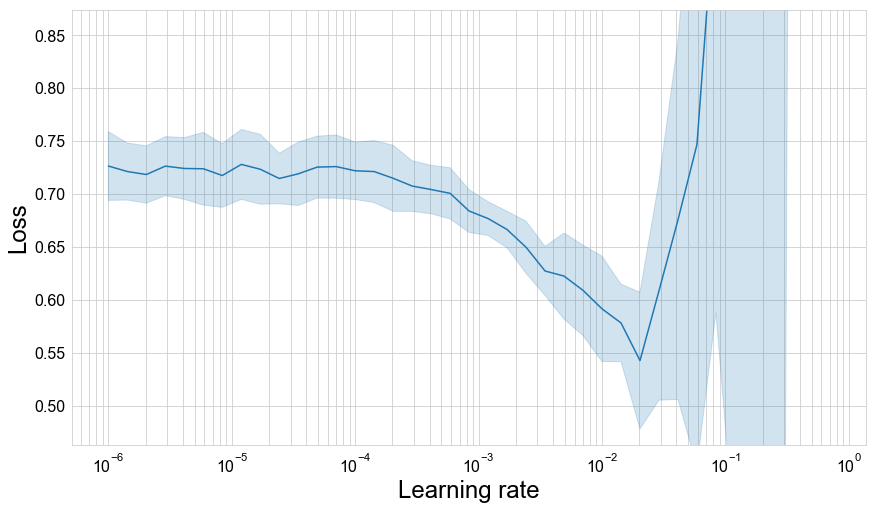

In [57]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

In [58]:
callback_partials[0].keywords['lr_range'] = [1e-4, 1e-2]

Training model 1 / 1, Val ID = 0


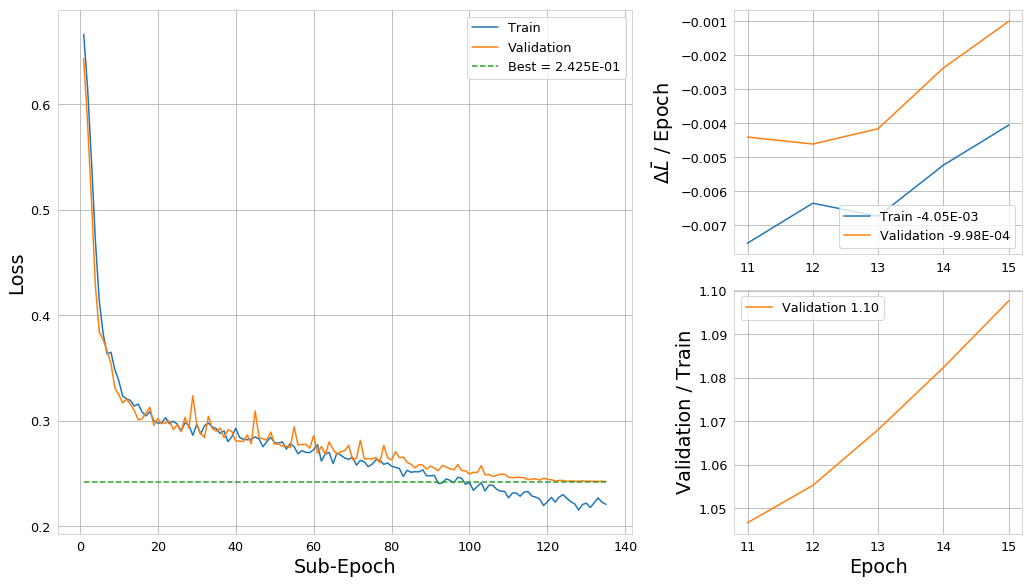

Early stopping after 135 epochs
Scores are: {'loss': 0.2424592226743698, 'AUC': 0.960413354664547}
Fold took 46.580s


______________________________________
Training finished
Cross-validation took 47.041s 


<Figure size 1024x576 with 0 Axes>

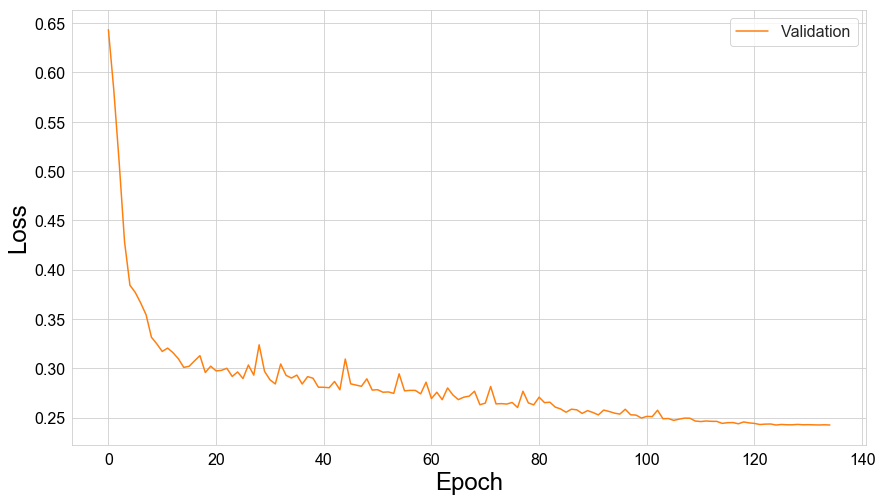

Mean loss = 0.2424592226743698±0.0
Mean AUC = 0.960413354664547±0.0
______________________________________



In [59]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

No indications of improvement from the extra variables.

Let's conclude by examining the eta values a bit. In general, the top-jets have lower $|\eta|$ than the QCD jets, as shown below:

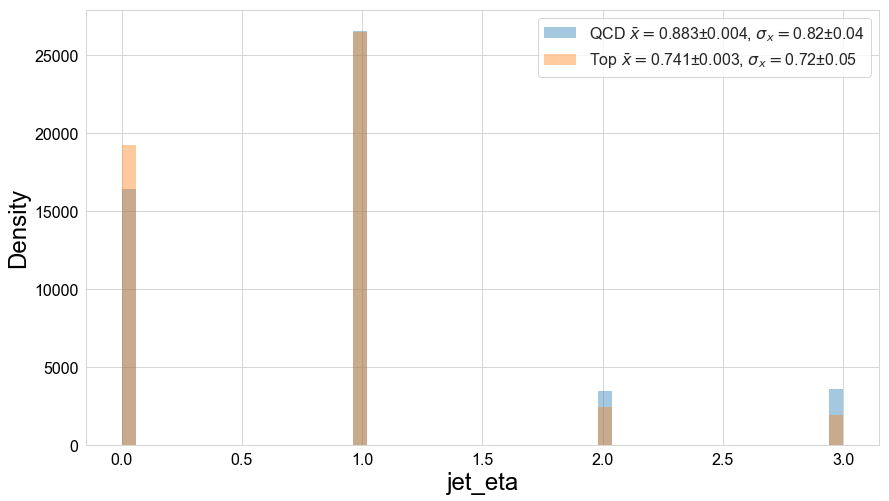

In [60]:
from lumin.plotting.data_viewing import plot_feat

plot_feat(df, feat='jet_eta', cuts=[(df.gen_target==0), (df.gen_target==1)], labels=['QCD', 'Top'],
          plot_bulk=False, plot_params={'kde':False})

We can also check the model's learned embedding for the jet eta, since we treated it as a categorical

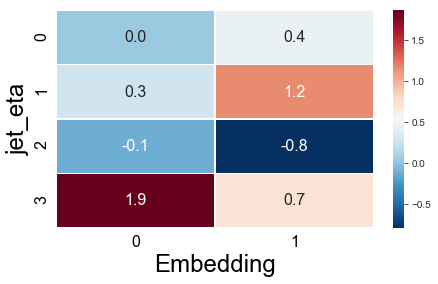

In [61]:
model = Model.from_save('train_weights/train_0.h5', model_builder)
model.head.flat_head.plot_embeds()

So the model finds it useful to encode each eta region separately. $|\eta|=1.7$ corresponds to the end of ATLAS's hadronic barrel calorimeter, and $1.5\leq|\eta|<3.2$ corresponds to the extend of its hadronic end-cap calorimeter. $|\eta|=1.5$ also marks the trasition of the Electromagnetic calorimeter from the barrel to the precision-region of the end-cap. The inner tracker of ATLAS covers the entire $|\eta|$ region of our data. It's not immedeately obvious what is the cause for the change in efficiency is at $|\eta|<0.5$, but according to the detector simulation, it affects charged-hadron tracking efficiency (as well as electrons and muons).